# Regression Feature Engineering

As we saw before, linear regression has to work on pure mathematical matrices of real numbers, respecting the normal equation:

$$\beta = (X^T X)^{-1}X^Ty$$

This means data that doesn't fit a matrix of real numbers has to be formatted to columns of real numbers (one per observation) so that we can ingest it into the $X$ matrix. This process is called **Feature Engineering**.

# Categorical Variables

If you have a categorical variable (can take one of many values), the standard way to encode it to a matrix form is [one-hot encoding](https://en.wikipedia.org/wiki/One-hot) (OHE --- AKA dummy variables). 

![](mtimFxh.png)

This can be done using `pd.get_dummies`:

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns

df = sns.load_dataset('titanic')

df['class'].unique()

[Third, First, Second]
Categories (3, object): [Third, First, Second]

In [23]:
pd.get_dummies(df['class'])

,First,Second,Third
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1
...,...,...,...
886,0,1,0
887,1,0,0
888,0,0,1
889,1,0,0


### Caveats of one-hot encoding

First, you need to drop one of the columns of the OHE matrix otherwise that matrix has full rank (at least one of the columns can be made as a combination from the others). 

Remember from lecture 3.1 how this causes a problem.

This can be fixed with the drop parameter in pd.get_dummies:

In [24]:
pd.get_dummies(df['class'], drop_first=True)

,Second,Third
0,0,1
1,0,0
2,0,1
3,0,0
4,0,1
...,...,...
886,1,0
887,0,0
888,0,1
889,0,0


Second, if a class is always there (columns of ones) or never there (column of zeroes) this also doesn't have full rank. Note `[0]` is any other column times 0 and `[1]` is 1 + any other column times 0)

# Interpreting 

The coefficient of a OHE variable is the effeect of being in that category compared to being in the dropped category.

For instance, let's predict how much people paid per gender:

In [25]:
import statsmodels.api as sm

sm.OLS(
    df.fare,
    sm.add_constant(
        pd.get_dummies(df.sex, drop_first=True)
    )
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   fare   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     30.57
Date:                Thu, 07 Jan 2021   Prob (F-statistic):           4.23e-08
Time:                        17:58:52   Log-Likelihood:                -4728.8
No. Observations:                 891   AIC:                             9462.
Df Residuals:                     889   BIC:                             9471.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.4798      2.759     16.122      0.000      39.065      49.895
male         -18.9559      3.428     -5.529      0.000     -25.685     -12.227
==============================================================================
Omnibus:                      918.036   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49432.048
Skew:                           4.857   Prob(JB):                         0.00
Kurtosis:                      38.173   Cond. No.                         3.13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Here, males paid `$18.96` less on average than females (the dropped category). Similar for class:

In [26]:
import statsmodels.api as sm

sm.OLS(
    df.fare,
    sm.add_constant(
        pd.get_dummies(df['class'], drop_first=True)
    )
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   fare   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     242.3
Date:                Thu, 07 Jan 2021   Prob (F-statistic):           1.03e-84
Time:                        17:59:41   Log-Likelihood:                -4549.9
No. Observations:                 891   AIC:                             9106.
Df Residuals:                     888   BIC:                             9120.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         84.1547      2.723     30.910      0.000      78.811      89.498
Second       -63.4925      4.014    -15.817      0.000     -71.371     -55.614
Third        -70.4791      3.267    -21.573      0.000     -76.891     -64.067
==============================================================================
Omnibus:                      975.994   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            85099.055
Skew:                           5.174   Prob(JB):                         0.00
Kurtosis:                      49.746   Cond. No.                         4.56
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Here the dropped category is first class, so second class paid `$63` less and third class `$70` less.

# Predicted component

Linear models are easy to interpret predictively. You add the coefficients with the feature values associated to get the prediction:

From this model we would predict a second class fare to be `84 - 63 = 21` dollars.

# Using OHE to fix features

There are many ways a feature can have problems. For instance, imagine the `fare` was registered as `50+` for all fares above $50:

<AxesSubplot:>

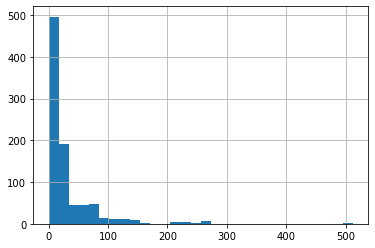

In [29]:
df.fare.hist(bins=30)

<AxesSubplot:>

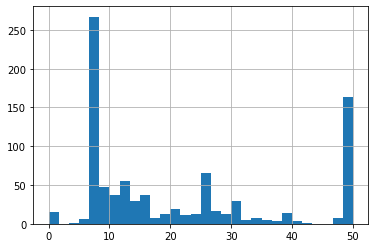

In [31]:
df.loc[df.fare > 50, 'fare'] = 50
df.fare.hist(bins=30)

If we were using something like fare to predict age, it would break the asusmptions of linear regression and the coefficient would be invalid (both to interpret and to predict/test).

We can enhance the regression by adding a categorical for the "clipped" fares:

In [42]:
# Note the astype int to cast the bool to a number
df['clipped_fare'] = (df.fare >= 50).astype(int)

df = df.dropna().reset_index(drop=True)

sm.OLS(
    df.age,
    sm.add_constant(df[['fare', 'clipped_fare']])
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    age   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.242
Date:                Thu, 07 Jan 2021   Prob (F-statistic):              0.291
Time:                        18:20:36   Log-Likelihood:                -757.33
No. Observations:                 182   AIC:                             1521.
Df Residuals:                     179   BIC:                             1530.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           30.1594      4.475      6.739      0.000      21.328      38.991
fare             0.2534      0.168      1.509      0.133      -0.078       0.585
clipped_fare    -7.6259      4.946     -1.542      0.125     -17.387       2.135
==============================================================================
Omnibus:                        0.407   Durbin-Watson:                   2.199
Prob(Omnibus):                  0.816   Jarque-Bera (JB):                0.553
Skew:                          -0.078   Prob(JB):                        0.758
Kurtosis:                       2.780   Cond. No.                         222.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Polynomial Coefficients

We saw polynomial coefficients before, and we saw that we can (ab)use them to overfit to any dataset (by [Taylor's theorem](https://en.wikipedia.org/wiki/Taylor%27s_theorem)) -- usually we restrict ourselves to degree 3 or lower.

**Interpretation**

You interpret the a feature with polynomial coefficients by everywhere it appears. So if you have $x + x^2$ then the coefficient interpretation is the parabola that fits the equation with the coefficients

In [43]:
# Note the astype int to cast the bool to a number
df['fare2'] = (df.fare ** 2)

df = df.dropna().reset_index(drop=True)

sm.OLS(
    df.age,
    sm.add_constant(df[['fare', 'fare2']])
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    age   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     2.809
Date:                Thu, 07 Jan 2021   Prob (F-statistic):             0.0629
Time:                        18:25:47   Log-Likelihood:                -755.77
No. Observations:                 182   AIC:                             1518.
Df Residuals:                     179   BIC:                             1527.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.4379      6.193      3.623      0.000      10.217      34.659
fare           1.0556      0.446      2.368      0.019       0.176       1.935
fare2         -0.0161      0.007     -2.347      0.020      -0.030      -0.003
==============================================================================
Omnibus:                        0.527   Durbin-Watson:                   2.180
Prob(Omnibus):                  0.768   Jarque-Bera (JB):                0.658
Skew:                          -0.107   Prob(JB):                        0.720
Kurtosis:                       2.799   Cond. No.                     1.10e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Here we have $1x - 0.01x^2$ so the prediction of this would be the parabola through that equation. These parabolas are sometimes iffy to predict far outside values of `x` seen in the model training data (they end up curving downwards or upwards severely at some point):

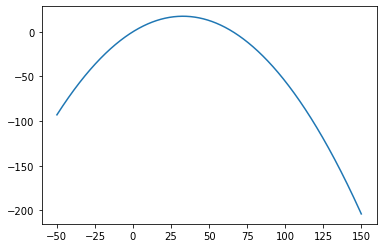

In [48]:
import matplotlib.pyplot as plt

x = np.linspace(-50,150,1000)
y = 1.0556*x - 0.0161 * (x**2)

plt.plot(x, y)

# Interaction Variables

If you multiply coefficients together, they create "interaction" variable. For instance we can do this with gender and class:

In [52]:
df['gender_class'] = df.sex.astype(str) + '_' + df['class'].astype(str)

sm.OLS(
    df.fare,
    sm.add_constant(
        pd.get_dummies(df['gender_class'], drop_first=True)
    )
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   fare   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     40.52
Date:                Thu, 07 Jan 2021   Prob (F-statistic):           1.34e-27
Time:                        18:34:11   Log-Likelihood:                -673.03
No. Observations:                 182   AIC:                             1358.
Df Residuals:                     176   BIC:                             1377.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            47.5558      1.155     41.188      0.000      45.277      49.834
female_Second   -32.6901      3.506     -9.323      0.000     -39.610     -25.770
female_Third    -34.1958      4.589     -7.451      0.000     -43.253     -25.138
male_First       -6.7353      1.588     -4.241      0.000      -9.869      -3.601
male_Second     -23.7433      4.216     -5.632      0.000     -32.064     -15.423
male_Third      -38.8608      4.589     -8.467      0.000     -47.918     -29.803
==============================================================================
Omnibus:                       56.907   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.759
Skew:                          -1.412   Prob(JB):                     2.98e-28
Kurtosis:                       5.956   Cond. No.                         7.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Here the effect is for these specific sub-categories. 

You can also do it a category and a continuous variable to capture the continuous variable's trend in that category:

In [54]:
# Note the astype int to cast the bool to a number
df['fare_male'] = df.fare * (df.sex =='male')

sm.OLS(
    df.age,
    sm.add_constant(df[['fare', 'fare2', 'fare_male']])
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    age   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     3.065
Date:                Thu, 07 Jan 2021   Prob (F-statistic):             0.0294
Time:                        18:36:01   Log-Likelihood:                -754.00
No. Observations:                 182   AIC:                             1516.
Df Residuals:                     178   BIC:                             1529.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.4996      6.176      3.805      0.000      11.311      35.688
fare           0.8740      0.453      1.929      0.055      -0.020       1.768
fare2         -0.0138      0.007     -1.990      0.048      -0.027      -0.000
fare_male      0.1028      0.055      1.870      0.063      -0.006       0.211
==============================================================================
Omnibus:                        0.790   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.674   Jarque-Bera (JB):                0.851
Skew:                          -0.154   Prob(JB):                        0.653
Kurtosis:                       2.867   Cond. No.                     1.10e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Here `fare_male` is the effect of the fare when male specifically. So `fare` is for women specifically by omission and fare2 is for both groups.